**Intel natural scenes dataset classification using Transferlearning Resnet50 and Adam**

In [1]:
import numpy as np
np.random.seed(123)  # for reproducibility
 
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.models import Model,load_model

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

import tensorflow as tf
import cv2
import keras.applications

# help(keras.applications)
# help(keras.applications.resnet)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
X_train,y_train = np.load('/content/drive/My Drive/train.npy',allow_pickle=True)
X_val,y_val = np.load('/content/drive/My Drive/val.npy',allow_pickle=True)
X_test,y_test = np.load('/content/drive/My Drive/test.npy',allow_pickle=True)

(150, 150, 3)


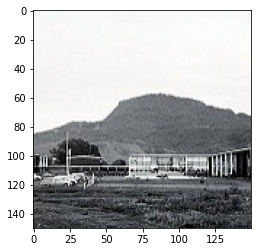

In [4]:
print(X_train[0].shape)
# print(y_test)
plt.imshow(X_train[0])
plt.show()

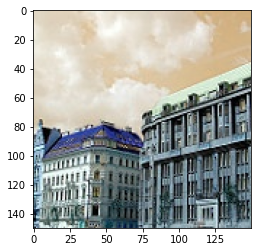

In [5]:
X_train,y_train = shuffle(X_train, y_train, random_state=0)

plt.imshow(X_train[1])
plt.show()

In [6]:
print('Number of train samples',X_train.shape[0])
print('Number of val samples',X_val.shape[0])
print('Number of test samples',X_test.shape[0])
print('Shape of Image: ',X_train[0].shape)

Number of train samples 14034
Number of val samples 3000
Number of test samples 7302
Shape of Image:  (150, 150, 3)


In [7]:
num_classes = 6
y_train = np_utils.to_categorical(y_train,num_classes)
y_val = np_utils.to_categorical(y_val,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

In [8]:
shape_to_resize_to = (224,224)
X_train_resized = []
for img in X_train:
  i = cv2.resize(img,shape_to_resize_to)
  X_train_resized.append(i)

X_train_resized = np.array(X_train_resized)
X_train = X_train_resized

X_val_resized = []
for img in X_val:
  i = cv2.resize(img,shape_to_resize_to)
  X_val_resized.append(i)

X_val_resized = np.array(X_val_resized)
X_val = X_val_resized

X_test = np.delete(X_test,6065,axis=0)
y_test = np.delete(y_test,6065,axis=0)
X_test_resized = []
for img in X_test:
  i = cv2.resize(img,shape_to_resize_to)
  X_test_resized.append(i)

X_test_resized = np.array(X_test_resized)
X_test = X_test_resized

print(X_train_resized.shape) 
print(X_val_resized.shape) 

(14034, 224, 224, 3)
(3000, 224, 224, 3)


In [9]:
model = ResNet50(include_top=False,weights='imagenet',input_shape=X_train[0].shape)

# add new classification layers
flat1 = Flatten()(model.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
output = Dense(6, activation='softmax')(class1) # add softmax layer

model = Model(inputs=model.inputs, outputs=output)
model.summary()


94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________

Epoch 1/10
110/110 [==============================] - 85s 667ms/step - loss: 0.9147 - accuracy: 0.7852 - val_loss: 0.2540 - val_accuracy: 0.9147
Epoch 2/10
110/110 [==============================] - 71s 645ms/step - loss: 0.0333 - accuracy: 0.9915 - val_loss: 0.2621 - val_accuracy: 0.9200
Epoch 3/10
110/110 [==============================] - 71s 645ms/step - loss: 0.0106 - accuracy: 0.9990 - val_loss: 0.2712 - val_accuracy: 0.9233
Epoch 4/10
110/110 [==============================] - 71s 646ms/step - loss: 0.0099 - accuracy: 0.9987 - val_loss: 0.2848 - val_accuracy: 0.9223
Epoch 5/10
110/110 [==============================] - 71s 645ms/step - loss: 0.0060 - accuracy: 0.9993 - val_loss: 0.2890 - val_accuracy: 0.9267
Epoch 6/10
110/110 [==============================] - 71s 646ms/step - loss: 0.0116 - accuracy: 0.9988 - val_loss: 0.2942 - val_accuracy: 0.9267
Epoch 7/10
110/110 [==============================] - 71s 645ms/step - loss: 0.0057 - accuracy: 0.9990 - val_loss: 0.2922 - val_ac

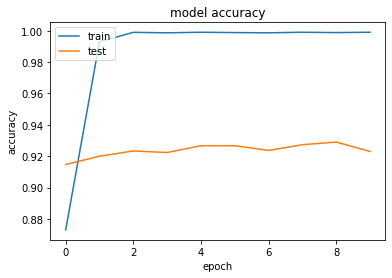

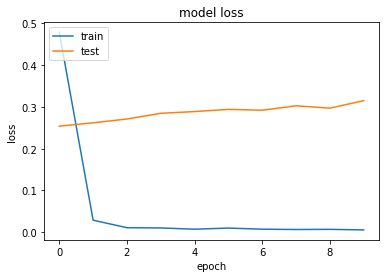

In [10]:
# 8. Compile model
adam = Adam(lr=2e-5)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])


# # 9. Fit model on training data

model_checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/My Drive/dbs-frozen.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128,
              epochs=10, 
              validation_data=(X_val, y_val),callbacks=[model_checkpoint_callback])
 
# Summarize history for acc 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() 

In [11]:
model = load_model('/content/drive/My Drive/dbs-frozen.h5')
score = model.evaluate(X_test, y_test)
print(score)

229/229 [==============================] - 15s 59ms/step - loss: 0.5242 - accuracy: 0.9014
[0.5242080688476562, 0.9013833999633789]


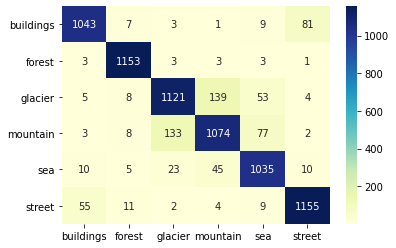

In [12]:
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred,axis=1)
y_test = np.argmax(y_test,axis=1)

confusion_mtx= confusion_matrix(y_test, y_pred)
target_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
sns.heatmap(confusion_mtx, xticklabels=target_names, yticklabels=target_names,
            annot=True, fmt='d', cmap="YlGnBu")

In [15]:
'''
Resnet50 model taken from example.ipynb

image size (224 * 224)
learning rate 2e-5
Test acc 89.84
----------------------------------------
Resnet50 model taken from example.ipynb
image size (224 * 224)
learning rate 2e-5
layers upto 143 freezed. Only the last conv block will be trained
Test acc 90 sth
----------------------------------------
Resnet50 model taken from example.ipynb
image size (224 * 224)
learning rate 2e-5
layers upto 143 freezed. Only the last conv block will be trained
ModelCheckpoint
Test acc 90.1 sth
'''

'\nResnet50 model taken from example.ipynb\n\nimage size (224 * 224)\nlearning rate 2e-5\nTest acc 89.84\n----------------------------------------\nResnet50 model taken from example.ipynb\nimage size (224 * 224)\nlearning rate 2e-5\nlayers upto 143 freezed. Only the last conv block will be trained\nTest acc 90 sth\n----------------------------------------\nResnet50 model taken from example.ipynb\nimage size (224 * 224)\nlearning rate 2e-5\nlayers upto 143 freezed. Only the last conv block will be trained\nModelCheckpoint\nTest acc 90.1 sth\n'

Guidance from visionatseecs github repos, blogs, tf.org tutorials, François Chollet’s book and others acknowledged